In [2]:
#dataset Splitting

import splitfolders
input_folder="D:\\deeplearning\\scratches\\data\\note_dataset"
output_folder = 'scratches/data/note_dataset_splitted'
splitfolders.ratio(input_folder,output="dataset",seed=42,ratio=(.7,.2,.1),group_prefix=None)

Copying files: 4583 files [00:18, 262.78 files/s]

KeyboardInterrupt: 

In [41]:
dataset_path = 'D:\\deeplearning\\scratches\\data\\note_dataset_splitted'

In [42]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import random

In [43]:
import os
print(os.listdir(dataset_path))
classes = os.listdir(dataset_path + "/train")
print(classes)
print(len(classes))

['test', 'train', 'val']
['10', '100', '1000', '2', '20', '200', '5', '50', '500']
9


In [46]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [47]:
from torchvision.datasets import ImageFolder
train_ds = ImageFolder(dataset_path+'/train',transform=train_transforms)
valid_ds= ImageFolder(dataset_path+'/val',transform=val_transforms)
len(train_ds)
len(valid_ds)

14305

In [48]:
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=100, shuffle=False)

In [49]:
batch_size=200



In [50]:
model = models.densenet121(pretrained=True)

# Freeze the layers except the last few
num_layers_to_unfreeze = 6
for param in model.parameters():
    param.requires_grad = False

# Count the total number of layers in the model
total_layers = len(list(model.modules())) - 1

# Calculate the starting point to unfreeze layers
start_layer = total_layers - num_layers_to_unfreeze

# Unfreeze the desired number of layers
for i, module in enumerate(model.modules()):
    if i >= start_layer:
        for param in module.parameters():
            param.requires_grad = True

# Replace the last layer for the new classification task
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 9)


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda', index=0)

In [53]:
val_accs=[]
val_losses=[]
train_losses=[]

In [54]:
from tqdm import tqdm
import time
num_epoch=4
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    t_start = time.time()

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_ds)
    train_losses.append(epoch_loss) # for storing history

    # Validate model
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss = val_loss / len(valid_ds)
    val_acc = val_correct.double() / len(valid_ds)

    #for storing history
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    t_end = time.time()
    epoch_time = t_end - t_start

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f} | Time: {epoch_time:.2f}s")

Epoch 1 | Train Loss: 0.301 | Val Loss: 0.160 | Val Acc: 0.965 | Time: 393.04s


Epoch 2 | Train Loss: 0.074 | Val Loss: 0.073 | Val Acc: 0.986 | Time: 129.65s


Epoch 3 | Train Loss: 0.051 | Val Loss: 0.053 | Val Acc: 0.989 | Time: 129.22s


Epoch 4 | Train Loss: 0.040 | Val Loss: 0.050 | Val Acc: 0.987 | Time: 131.52s


In [58]:
  test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(dataset_path+'/test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [61]:
train_losses,val_losses,val_accs
val_accs =torch.tensor(val_accs)
val_accs=val_accs.tolist()
val_accs

[0.9651170969009399,
 0.9860188961029053,
 0.9892345070838928,
 0.9872771501541138]

In [60]:

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(correct/total)*100}%")

Accuracy on test set: 98.79921809550405%


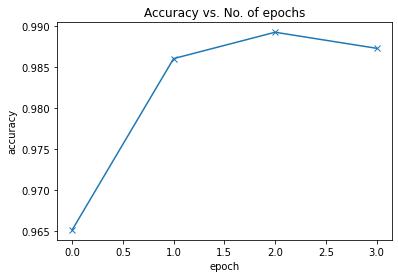

In [62]:
import matplotlib.pyplot as plt
def plot_accuracies(accuracy):

    plt.plot(val_accs, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
plot_accuracies(val_accs)

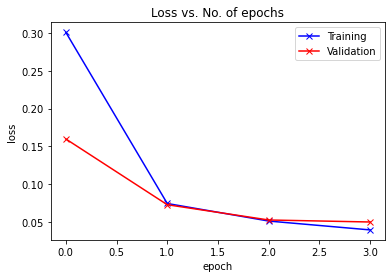

In [63]:
def plot_losses(trainloss,valloss):


    plt.plot(trainloss, '-bx')
    plt.plot(valloss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])

    plt.title('Loss vs. No. of epochs')
plot_losses(train_losses,val_losses)